## Question 1

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


## Exemple Pratique : Classification des Penguins

Dans cet exemple le nombre de classes est connu : G = 3

**PENGUINS**

<div>
    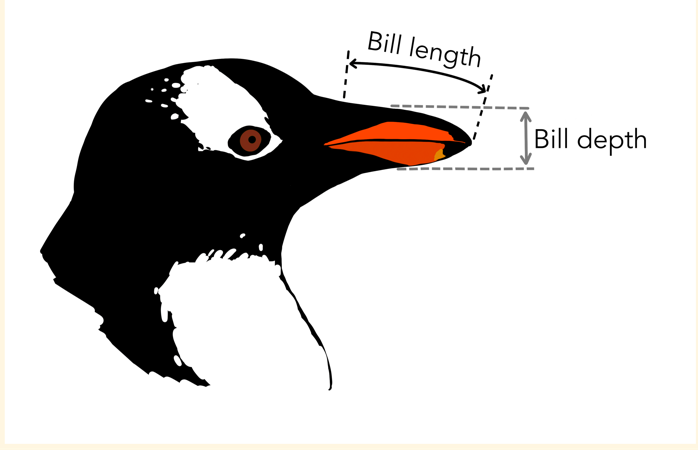
</div>

Aperçu des données :

In [2]:
penguins = pd.read_csv("penguins.csv")
# penguins.dropna(inplace=True)
penguins = penguins.sample(frac=1, random_state=5).reset_index(drop=True).dropna()
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
1,Gentoo,Biscoe,48.5,15.0,219.0,4850.0,FEMALE
2,Adelie,Torgersen,40.9,16.8,191.0,3700.0,FEMALE
3,Gentoo,Biscoe,46.8,16.1,215.0,5500.0,MALE
4,Adelie,Dream,36.0,18.5,186.0,3100.0,FEMALE
5,Adelie,Biscoe,37.6,17.0,185.0,3600.0,FEMALE
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,43.3,13.4,209.0,4400.0,FEMALE
340,Adelie,Torgersen,45.8,18.9,197.0,4150.0,MALE
341,Adelie,Torgersen,35.7,17.0,189.0,3350.0,FEMALE
342,Chinstrap,Dream,52.0,20.7,210.0,4800.0,MALE


In [3]:
penguins.loc[penguins.isnull().any(axis=1)].size

0

Le Clustering se focalisera donc sur la variable "Species".

Visualisons brievemment la distribution des variables quantitatives : 

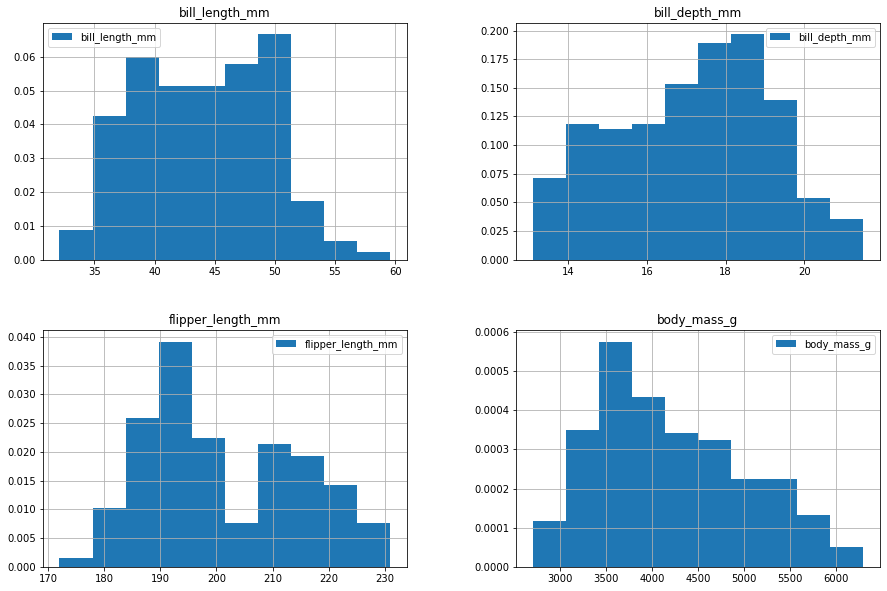

In [4]:
penguins.loc[:,"bill_length_mm":"body_mass_g"].hist(figsize=(15, 10), legend=True, density=True);

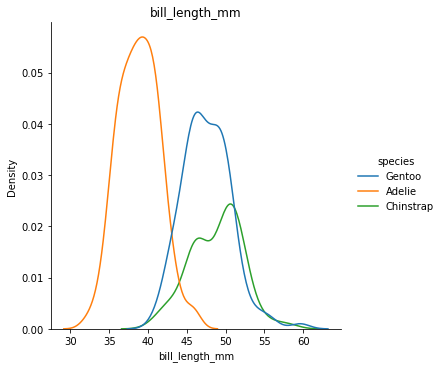

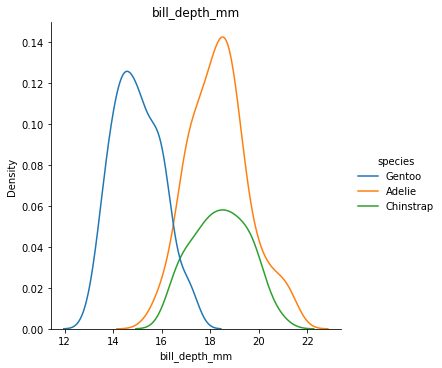

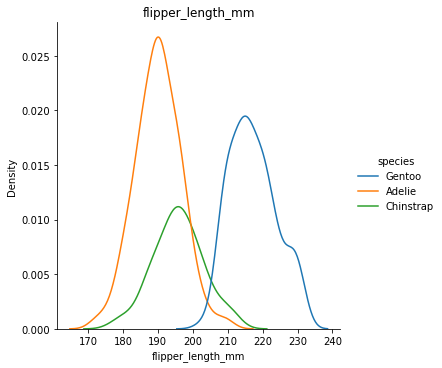

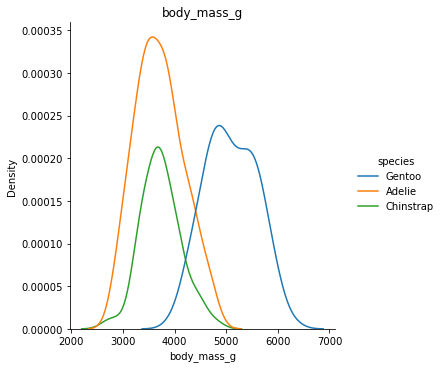

In [5]:
for k in penguins.loc[:,"bill_length_mm":"body_mass_g"].columns:
    sns.displot(data=penguins,x=penguins[k], hue="species", kind='kde');
    plt.title(k)
    plt.show()
    print("\n\n")

## Cas simplifié où d = 1 (donc une seule variable de sélectionnée)

Nous allons travailler avec la variable `bill_depth_mm` que l'on va modifier pour plus de facilité (augmentation de la moyenne de 3mm pour la courbe verte représentant l'espèce Chinstrap).

In [6]:
penguins = penguins.set_index("species")
penguins.loc["Chinstrap", "bill_depth_mm"] = penguins.loc["Chinstrap", "bill_depth_mm"] + 3
penguins.reset_index(inplace=True)

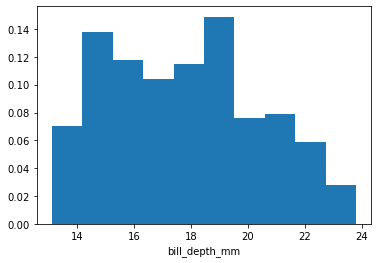

In [7]:
plt.hist(penguins["bill_depth_mm"], density=True);
plt.xlabel("bill_depth_mm");

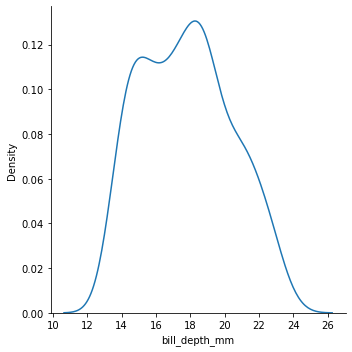

In [8]:
sns.displot(data=penguins, x="bill_depth_mm", kind="kde");

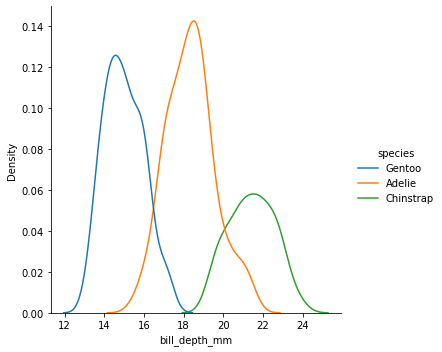

In [9]:
sns.displot(data=penguins, x="bill_depth_mm", hue="species", kind="kde");

In [10]:
var_1 = penguins[["bill_depth_mm"]].sample(frac=1, random_state=5).reset_index(drop=True)
var_1 # Variable "bill_depth_mm mélangée"

,bill_depth_mm
0,16.1
1,20.7
2,18.0
3,15.1
4,20.9
...,...
328,17.5
329,20.1
330,14.4
331,17.9


### Présentation de l'algorithme EM dans notre exemple (G = 3, d = 1)

<div>
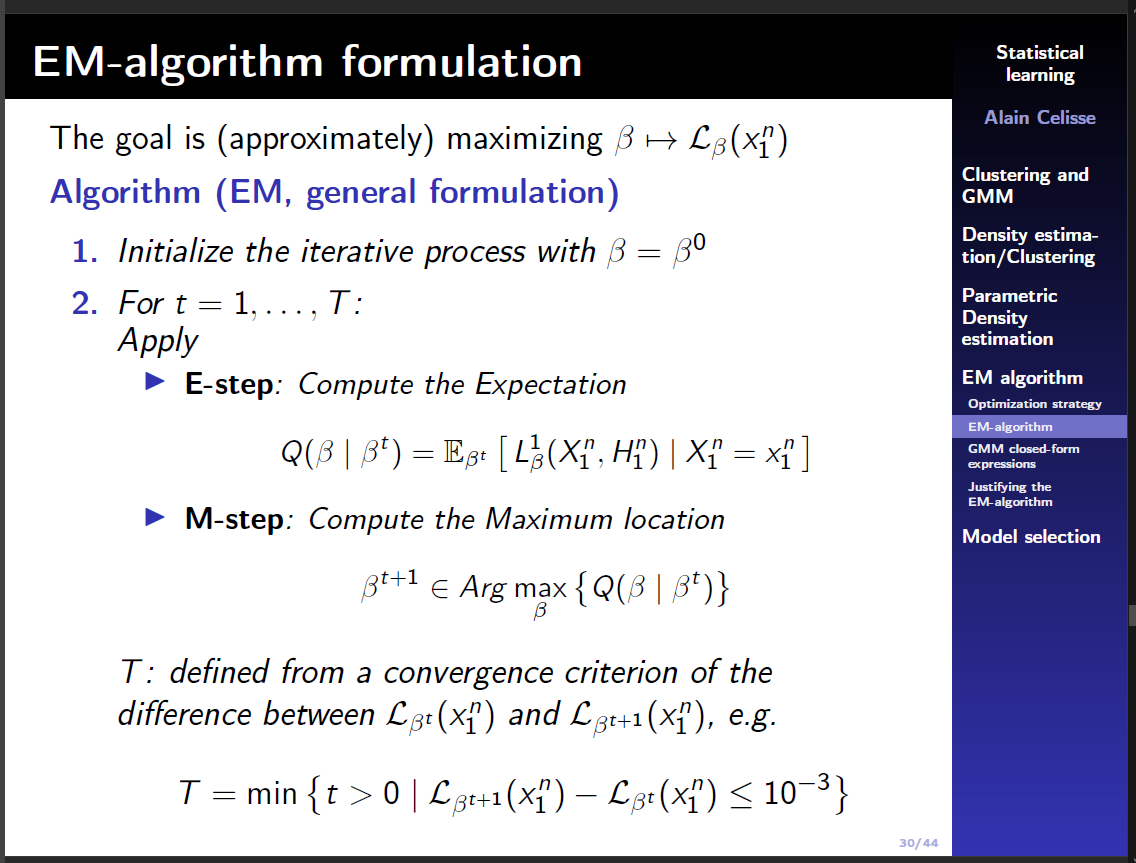
</div>

<div>
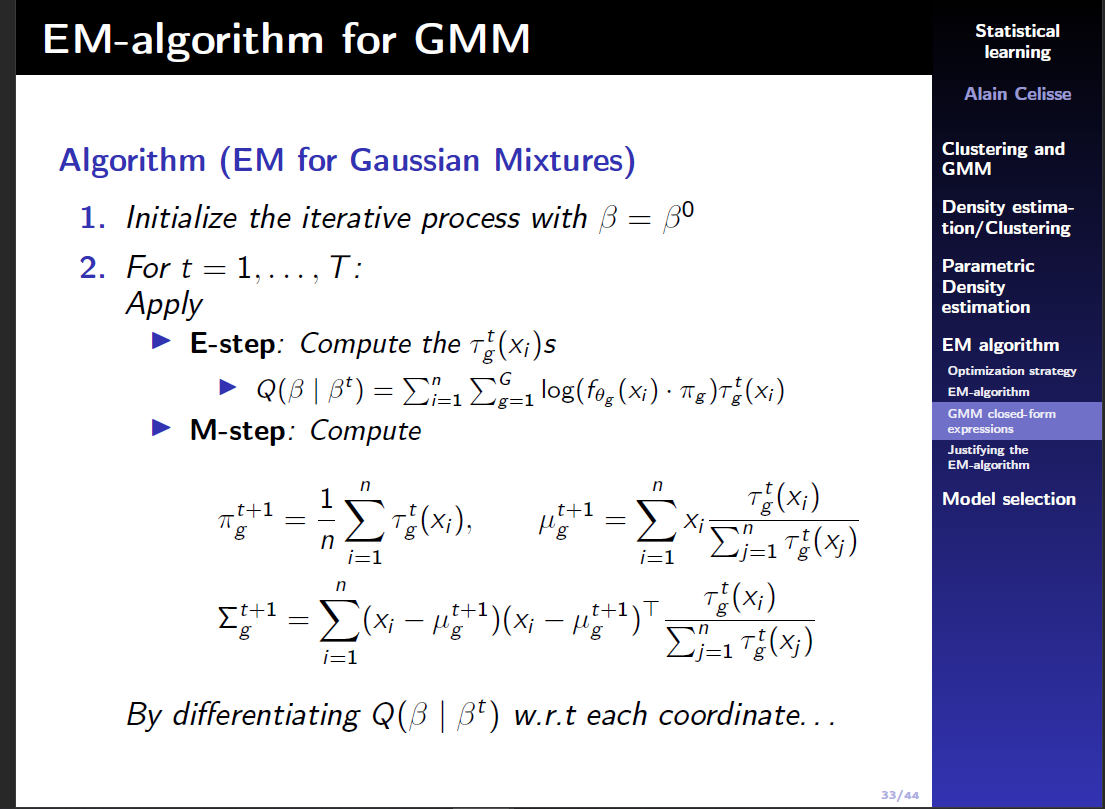
</div>

Tout d'abord, on construit la fonction densité d'une loi normale

In [11]:
def f(mean, sd, x):
    return (1/np.sqrt(2*np.pi*sd**2))*np.exp(-1/2*(((x - mean)/sd)**2))

Observons dans un premier temps les moyennes et écart-type que l'algorithme EM est censé retrouver

 cluster_1 : mean = 14.997, sd = 0.986
 cluster_2 : mean = 18.347, sd = 1.219
 cluster_3 : mean = 21.421, sd = 1.135


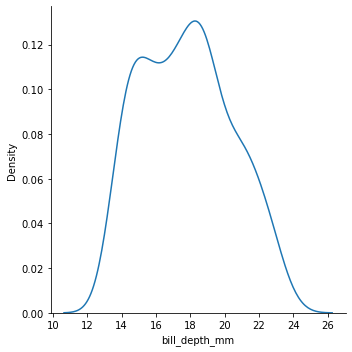

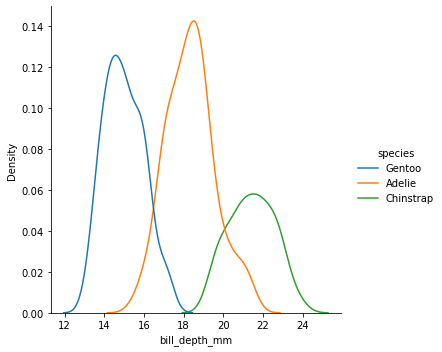

In [127]:
#Ce qu'on devrait retrouver

def true_args(variable):
    g_1 = penguins.loc[penguins["species"]=="Gentoo", variable]
    g_2 = penguins.loc[penguins["species"]=="Adelie", variable]
    g_3 = penguins.loc[penguins["species"]=="Chinstrap", variable]

    print(f" cluster_1 : mean = {g_1.mean():.3f}, sd = {g_1.std():.3f}\n",
          f"cluster_2 : mean = {g_2.mean():.3f}, sd = {g_2.std():.3f}\n",
          f"cluster_3 : mean = {g_3.mean():.3f}, sd = {g_3.std():.3f}")

    sns.displot(data=penguins, x=variable, kind="kde");
    sns.displot(data=penguins, x=variable, kind="kde", hue="species");

true_args("bill_depth_mm")

**Notre Algorithme:**

In [132]:
def EM_1d(data, beta_g1, beta_g2, beta_g3, stop):
    """data : Series type (or DataFrame nx1)
       beta_gi : [pi_gi, m_gi, sd_gi]
       stop : error threshold"""
    n = len(data)
    data = np.array(data.tolist())
    pi_g1, m_g1, sd_g1 = beta_g1[0], beta_g1[1], beta_g1[2]
    pi_g2, m_g2, sd_g2 = beta_g2[0], beta_g2[1], beta_g2[2]    
    pi_g3, m_g3, sd_g3 = beta_g3[0], beta_g3[1], beta_g3[2]
    
    Q_diff = np.infty
    Q = 0
    while Q_diff > stop: #essai avec 3 itération de l'algo
        f_g1, f_g2, f_g3 = f(m_g1, sd_g1, data), f(m_g2, sd_g2, data), f(m_g3, sd_g3, data)

        tau_1, tau_2, tau_3 = pi_g1*f_g1, pi_g2*f_g2, pi_g3*f_g3
        tau = tau_1 + tau_2 + tau_3
        
        T_1, T_2, T_3 = tau_1/tau, tau_2/tau, tau_3/tau
        
        sum_log = np.sum(np.log(tau_1)*T_1 +
                         np.log(tau_2)*T_2 +
                         np.log(tau_3)*T_3)
        
        
        
        Q, Q_diff = sum_log , abs(sum_log - Q)
        
        m_g1 = np.sum(T_1 * data)/np.sum(T_1) 
        m_g2 = np.sum(T_2 * data)/np.sum(T_2) 
        m_g3 = np.sum(T_3 * data)/np.sum(T_3)


        sd_g1 = np.sqrt(np.sum(T_1*(data - m_g1)**2)/np.sum(T_1))
        sd_g2 = np.sqrt(np.sum(T_2*(data - m_g2)**2)/np.sum(T_2))
        sd_g3 = np.sqrt(np.sum(T_3*(data - m_g3)**2)/np.sum(T_3))

        pi_g1 = np.sum(T_1)/n
        pi_g2 = np.sum(T_2)/n
        pi_g3 = np.sum(T_3)/n

    print("Dernière itération :")
    print(f"cluster_G1 : mean {m_g1:.3f} sd {sd_g1:.3f}")
    print(f"cluster_G2 : mean {m_g2:.3f} sd {sd_g2:.3f}")
    print(f"cluster_G3 : mean {m_g3:.3f} sd {sd_g3:.3f}")
    print(f"Q_diff = {Q_diff}")
    print(f"Q = {Q:.5f}\n\n")
    
    
    g1= np.random.normal(m_g1, sd_g1, n)
    g2= np.random.normal(m_g2, sd_g2, n)
    g3= np.random.normal(m_g3, sd_g3, n)
    
    sns.displot(data=[g1, g2, g3], kind="kde");
    
    return Q


Dernière itération :
cluster_G1 : mean 14.572 sd 0.731
cluster_G2 : mean 18.034 sd 1.703
cluster_G3 : mean 21.803 sd 0.938
Q_diff = 9.88618046449119e-06
Q = -860.52786




-860.527864216133

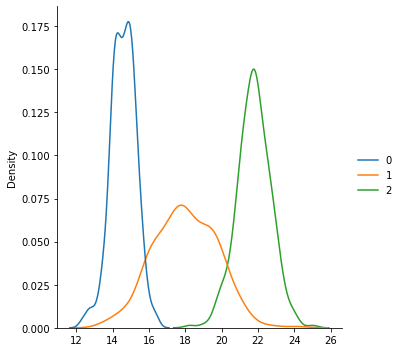

In [133]:
EM_1d(penguins["bill_depth_mm"], [1/3, 10, 3], [1/3, 20, 2], [1/3, 25, 4], 1e-5)

### Calcule du BIC

- Pour la variable `bill_depth_mm`

Dernière itération :
cluster_G1 : mean 14.572 sd 0.731
cluster_G2 : mean 18.034 sd 1.703
cluster_G3 : mean 21.803 sd 0.938
Q_diff = 9.726441396651353e-05
Q = -860.52542




-863.4294926939847

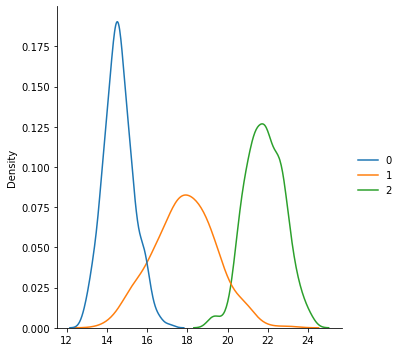

In [134]:
d = 1
n = len(penguins)
Q = EM_1d(penguins["bill_depth_mm"], [1/3, 10, 3], [1/3, 20, 2], [1/3, 25, 4], 1e-4)
BIC = Q -d/2*np.log(n)
BIC

- Pour la variable `bill_length_mm`

On affiche d'abord les "vrais paramètres" des clusters :

 cluster_1 : mean = 47.568, sd = 3.106
 cluster_2 : mean = 38.824, sd = 2.663
 cluster_3 : mean = 48.834, sd = 3.339


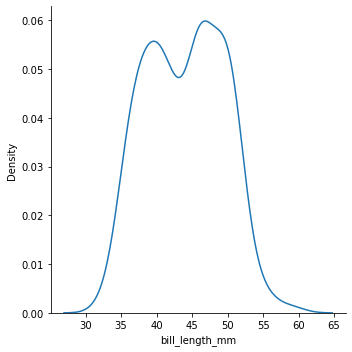

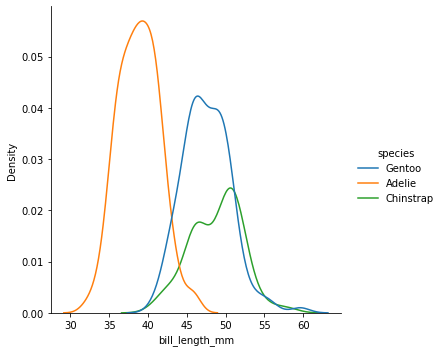

In [135]:
true_args("bill_length_mm")

Calcul du **BIC** :

Dernière itération :
cluster_G1 : mean 38.499 sd 2.505
cluster_G2 : mean 45.999 sd 4.712
cluster_G3 : mean 48.410 sd 2.547
Q_diff = 7.597393346259196e-05
Q = -1220.01007


Le BIC est égal à  -1222.9141437324824


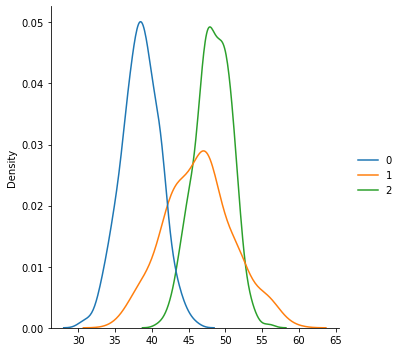

In [136]:
Q_2 = EM_1d(penguins["bill_length_mm"], [1/3, 30, 6], [1/3, 50, 4], [1/3, 49, 3], 1e-4)
BIC_2 = Q_2 -d/2*np.log(n)
print("Le BIC est égal à ",BIC_2)

- Pour la variable `body_mass_g`

Idem, on affiche les "vrais paramètres" :

 cluster_1 : mean = 5092.437, sd = 501.476
 cluster_2 : mean = 3706.164, sd = 458.620
 cluster_3 : mean = 3733.088, sd = 384.335


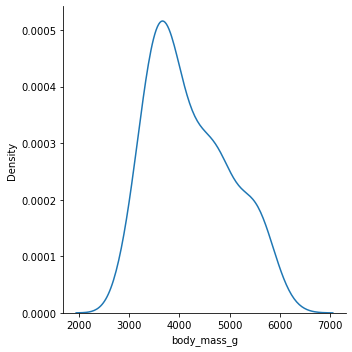

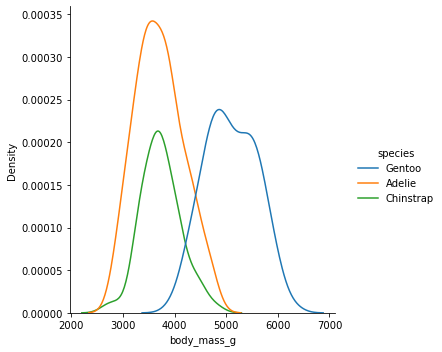

In [137]:
true_args("body_mass_g")

Calcul du **BIC** :

Dernière itération :
cluster_G1 : mean 4627.079 sd 394.869
cluster_G2 : mean 5564.869 sd 283.026
cluster_G3 : mean 3599.139 sd 355.624
Q_diff = 9.934249465004541e-05
Q = -2753.60648


Le BIC est égal à  -2756.5105531159156


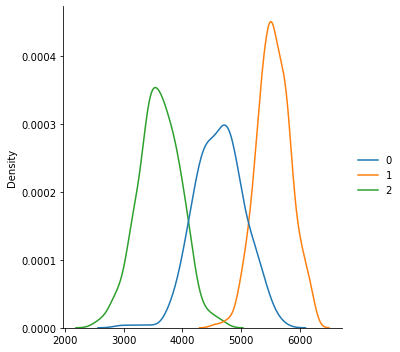

In [141]:
Q_3 = EM_1d(penguins["body_mass_g"], [1/3, 3000, 600], [1/3, 5500, 700], [1/3, 3400, 400], 1e-4)
BIC_3 = Q_3 -d/2*np.log(n)
print("Le BIC est égal à ",BIC_3)

**Remarques :**
- On ne sait pas comment fournir des graphiques plus adéquats.
- Comment avoir une initialisation optimale ?
- Comment faire si G est inconnu ?

## Question 2

In [ ]:
df_red = pd.read_csv("winequality-red.csv", delimiter=";")
df_red

In [ ]:
df_white = pd.read_csv("winequality-white.csv", delimiter=";")
df_white

In [ ]:
df_test = pd.concat([df_white, df_red]).sample(frac=1).reset_index(drop=True)
df_test